In [62]:
import pandas as pd
# import glob
# from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import joblib
from tabulate import tabulate

# data science libraries
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [63]:
rng = np.random.RandomState(42)

In [64]:
def load_data(file_path: str, **kwargs) -> pd.DataFrame:
    """
    Load data from a CSV file.
    
    Parameters:
    file_path (str): Path to the CSV file.
    
    Returns:
    pd.DataFrame: Loaded DataFrame.
    """
    
    df = pd.read_csv(file_path, **kwargs)
    if df.shape == 1:
        df = df.iloc[:,0]
        
    print(f"Data loaded from {file_path}")
    print(f"DataFrame Shape: {df.shape}")
    print(tabulate(df.head(), headers='keys', tablefmt='pretty', showindex=False, floatfmt=".2f"))
    # print(f"DataFrame Head:\n{df.head()}")
    print(tabulate(df.tail(), headers='keys', tablefmt='pretty', showindex=False, floatfmt=".2f"))
    # print(f"DataFrame Tail:\n{df.tail()}")
    print(f"DataFrame Columns:\n{df.columns}")
    print(f"DataFrame Info:\n{df.info()}")
    # print(f"DataFrame Description:\n{df.describe()}")
    
    return df
def get_colnames_with_prefix(df, prefix):
    """
    Get column names with a specific prefix from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to search.
    prefix (str): The prefix to search for.
    
    Returns:
    list: List of column names with the specified prefix.
    """
    
    return [col for col in df.columns if col.startswith(prefix)]

def get_colnames_with_suffix(df, suffix):
    """
    Get column names with a specific suffix from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to search.
    suffix (str): The suffix to search for.
    
    Returns:
    list: List of column names with the specified suffix.
    """
    
    return [col for col in df.columns if col.endswith(suffix)]

def execute_pipeline(df_in: pd.DataFrame, steps: list) -> pd.DataFrame:
    """
    Execute a pipeline of preprocessing steps on the DataFrame.
    
    Parameters:
    df_in (pd.DataFrame): Input DataFrame.
    steps (list): List of preprocessing steps to apply.
    
    Returns:
    pd.DataFrame: Processed DataFrame.
    """
    
    for step in steps:
        df_in = step(df_in)
    
    return df_in


# def get_X_y(df):
#     """
#     Split the DataFrame (train, test, holdout) into features (X) and target variable (y).
    
#     Parameters:
#     df (pd.DataFrame): The DataFrame to split.
    
#     Returns:
#     X (pd.DataFrame): Features DataFrame.
#     y (pd.Series): Target variable Series.
#     """
#     target_var = 'In-hospital_death'
#     X = df.drop(columns=[target_var]) # features
#     y = df[target_var] # target
    
#     return X, y

# def get_train_test_holdout(X, y, test_size=0.2, holdout_size=0.2):
#     """
#     Split the data into train, test, and holdout sets.
    
#     Parameters:
#     X (pd.DataFrame): Features DataFrame.
#     y (pd.Series): Target variable Series.
#     test_size (float): Proportion of the data to include in the test set.
#     holdout_size (float): Proportion of the data to include in the holdout set.
    
#     Returns:
#     X_train (pd.DataFrame): Training features DataFrame.
#     X_test (pd.DataFrame): Testing features DataFrame.
#     X_holdout (pd.DataFrame): Holdout features DataFrame.
#     y_train (pd.Series): Training target variable Series.
#     y_test (pd.Series): Testing target variable Series.
#     y_holdout (pd.Series): Holdout target variable Series.
#     """


#     # Split into train+test and holdout
#     X_train_test, X_holdout, y_train_test, y_holdout = train_test_split(X, y, test_size=holdout_size, stratify=y)
    
#     # Split into train and test
#     X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=test_size/(1-holdout_size), stratify=y_train_test)

#     # Print the shapes of the splits
#     print("\nTrain, Test, Holdout Split Shapes:")
#     print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
#     print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print(f"X_holdout: {X_holdout.shape}, y_holdout: {y_holdout.shape}")
#     # Print the distribution of the target variable in each split
#     print("\nTarget Variable Distribution:")
#     print(f"y_train:\n{y_train.value_counts(normalize=True)}")
#     print(f"y_test:\n{y_test.value_counts(normalize=True)}")
#     print(f"y_holdout:\n{y_holdout.value_counts(normalize=True)}")
#     # Print the distribution of the target variable in the entire dataset
#     print(f"\nFull Dataset:\n{y.value_counts(normalize=True)}")
    
#     return X_train, X_test, X_holdout, y_train, y_test, y_holdout

def get_stratified_kfold(X, y, n_splits=5):
    """
    Create a Stratified K-Folds cross-validator.
    
    Parameters:
    X (pd.DataFrame): Features DataFrame.
    y (pd.Series): Target variable Series.
    n_splits (int): Number of splits for K-Folds.
    
    Returns:
    StratifiedKFold: Stratified K-Folds cross-validator object.
    """
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
    
    return skf.split(X, y)

def get_feature_importances(model, X, y):
    """
    Get feature importances from a fitted model.
    
    Parameters:
    model: Fitted model object.
    X (pd.DataFrame): Features DataFrame.
    y (pd.Series): Target variable Series.
    
    Returns:
    pd.DataFrame: DataFrame of feature importances.
    """
    
    # Fit the model
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame of feature importances
    feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)
    
    return feature_importances

def plot_feature_importances(feature_importances, n=10):
    """
    Plot the top n feature importances.
    
    Parameters:
    feature_importances (pd.DataFrame): DataFrame of feature importances.
    n (int): Number of top features to plot.
    
    Returns:
    None
    """
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances["Importance"][:n], y=feature_importances.index[:n])
    plt.title("Top Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

def save_model(model, filename):
    """
    Save the model to a file.
    
    Parameters:
    model: Model object to save.
    filename (str): Filename to save the model.
    
    Returns:
    None
    """
    
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def load_model(filename):
    """
    Load the model from a file.
    
    Parameters:
    filename (str): Filename to load the model from.
    
    Returns:
    Model object: Loaded model.
    """
    
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set.
    
    Parameters:
    model: Fitted model object.
    X_test (pd.DataFrame): Testing features DataFrame.
    y_test (pd.Series): Testing target variable Series.
    
    Returns:
    None
    """
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # # Calculate accuracy
    # accuracy = np.mean(y_pred == y_test)
    
    # print(f"Model Accuracy: {accuracy:.2%}")
    # calculate PR AUC
    print("Calculating PR AUC...")
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    print(f"Model PR AUC: {pr_auc:.2f}")
    # plot PR curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # create a confusion matrix
    print
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    # print classification report
    
    print("Classification Report:")
    # print(classification_report(y_test, y_pred, target_names=model.classes_))
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in model.classes_]))

    # calibration curve
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_test, model.predict_proba(X_test)[:, 1], n_bins=10)
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

In [65]:
# read the cleaned splits
X_train_cleaned, X_test_cleaned, X_holdout_cleaned,y_train, y_test, y_holdout = joblib.load("split_data_cleaned.joblib")

In [66]:
# Define the scoring metric (e.g., F2 score)
ftwo_score = make_scorer(fbeta_score, beta=2)

Training logistic_regression model...


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    random_state=RandomState(MT19937) at 0x7AD04FF43840,
                                    solver='liblinear'))])

Calculating PR AUC...
Model PR AUC: 0.53


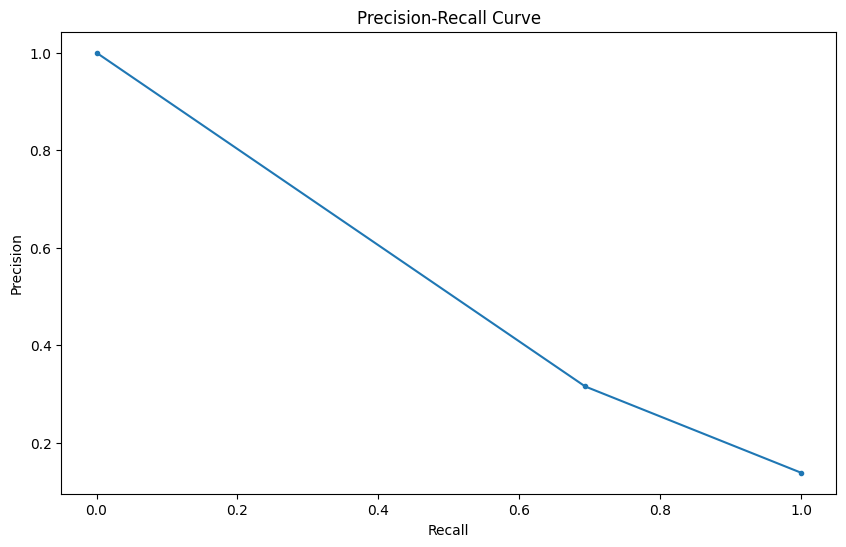

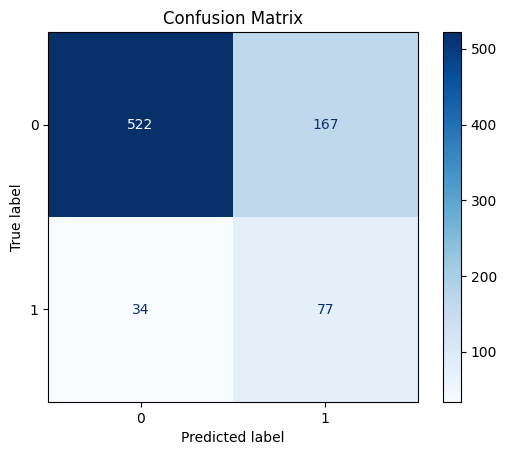

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       689
           1       0.32      0.69      0.43       111

    accuracy                           0.75       800
   macro avg       0.63      0.73      0.64       800
weighted avg       0.85      0.75      0.78       800



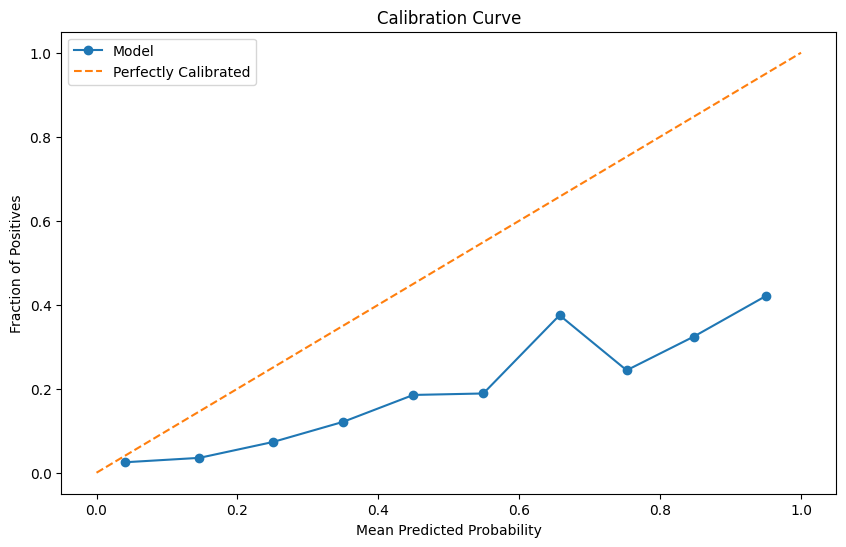

logistic_regression model does not have feature importances.
Training random_forest model...


Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=RandomState(MT19937) at 0x7AD04FF43840))])

Calculating PR AUC...
Model PR AUC: 0.33


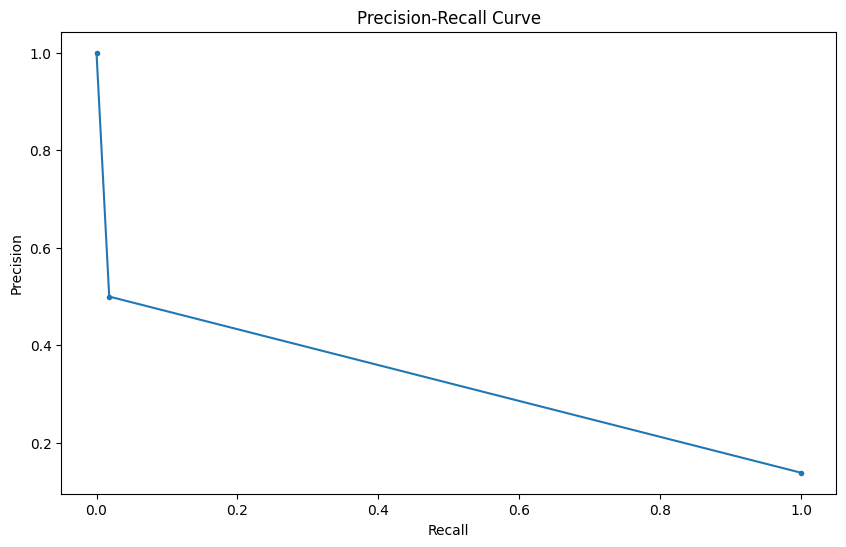

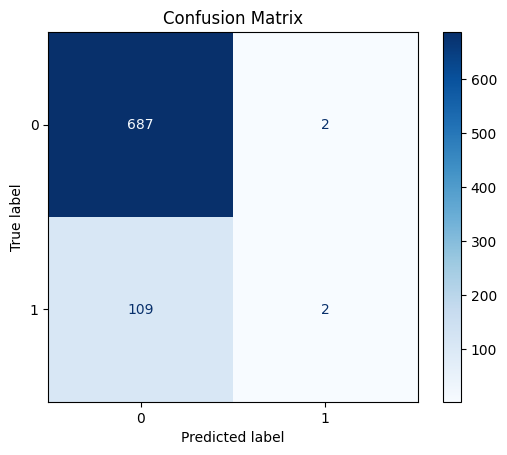

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       689
           1       0.50      0.02      0.03       111

    accuracy                           0.86       800
   macro avg       0.68      0.51      0.48       800
weighted avg       0.81      0.86      0.80       800



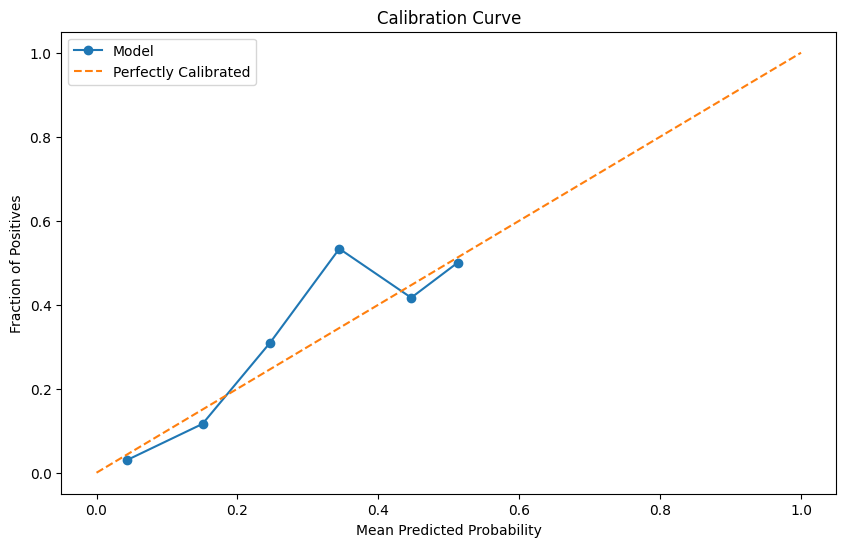

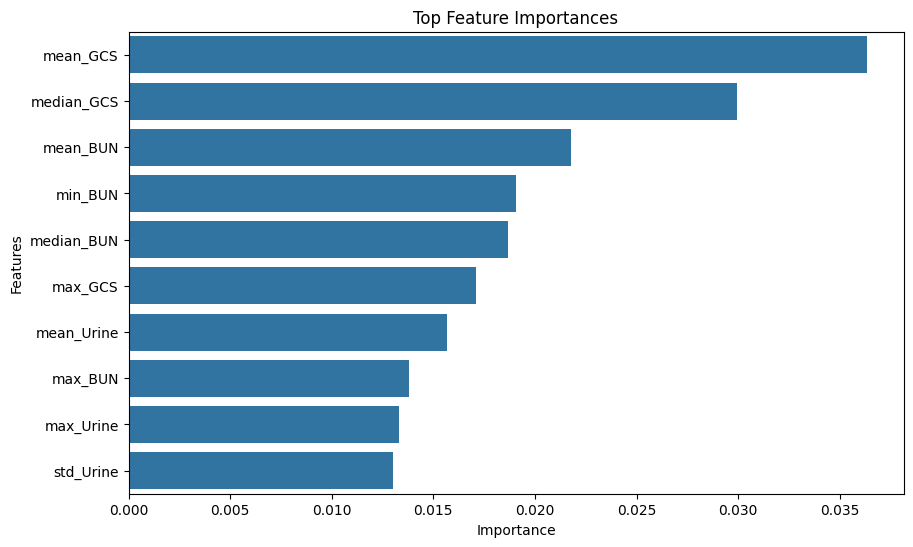

Training xgboost model...


Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

Calculating PR AUC...
Model PR AUC: 0.40


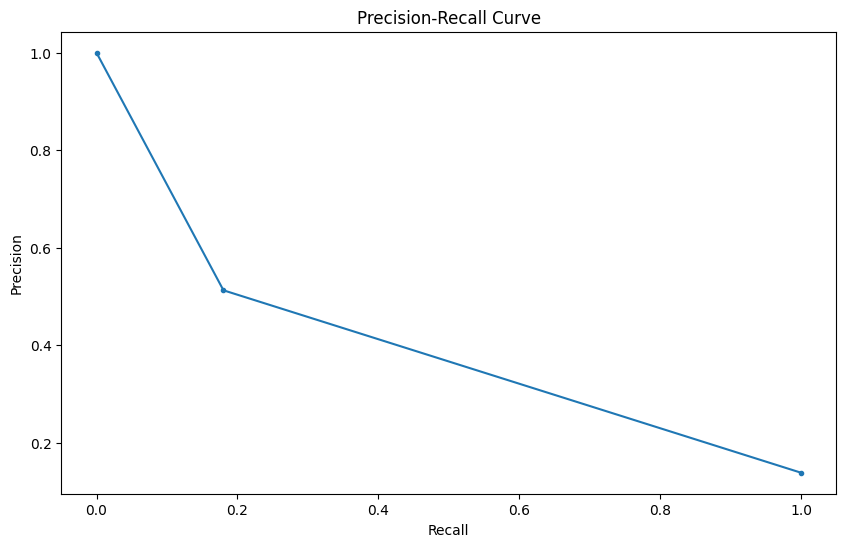

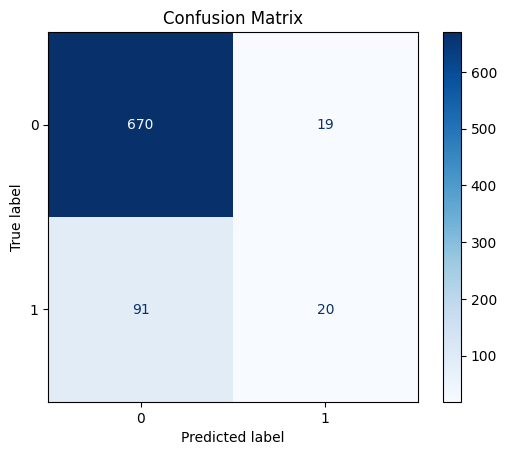

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       689
           1       0.51      0.18      0.27       111

    accuracy                           0.86       800
   macro avg       0.70      0.58      0.60       800
weighted avg       0.83      0.86      0.83       800



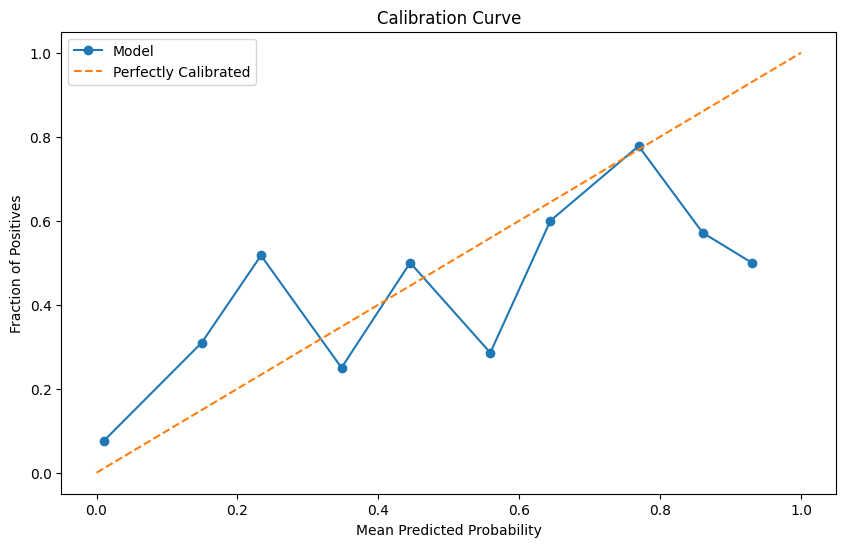

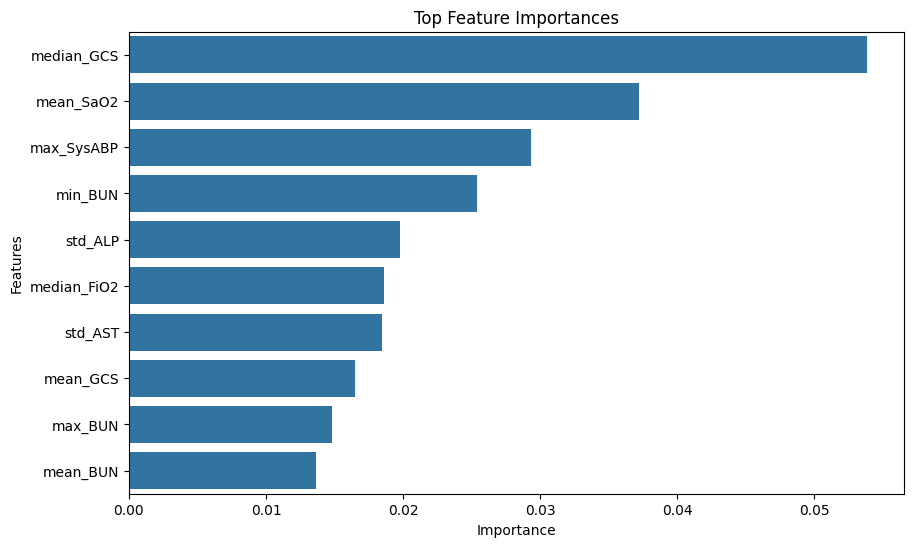

In [67]:
# run logistic regression & random forest
model_factory = {
    'logistic_regression': Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(solver='liblinear', random_state=rng, class_weight='balanced'))
    ]),
    'random_forest': Pipeline([
        # ('imputer', KNNImputer(n_neighbors=5)),
        # ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced')) 
    ]),
    'xgboost': Pipeline([
        # ('imputer', KNNImputer(n_neighbors=5)),
        # ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=rng, scorer= ftwo_score))
    ])
}


for model_name, model in model_factory.items():
    print(f"Training {model_name} model...")
    model.fit(X_train_cleaned, y_train)
    evaluate_model(model, X_test_cleaned, y_test)
    # plot feature importances
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        feature_importances = get_feature_importances(model.named_steps['classifier'], X_train_cleaned, y_train)
        n_features_to_plot = min(10, len(feature_importances))
        plot_feature_importances(feature_importances, n=n_features_to_plot)
    else:
        print(f"{model_name} model does not have feature importances.")   
        
        
        

In [68]:


# # Lets get baseline logistic regression model
# logreg_model = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', StandardScaler()),
#     ('classifier', LogisticRegression(solver='liblinear', random_state=rng, class_weight='balanced'))
# ])
# logreg_model.fit(X_train_cleaned, y_train)
# y_pred = logreg_model.predict(X_test_cleaned)

# # evaluate the logistic regression model
# # create PR AUC curve

# evaluate_model(logreg_model, X_test_cleaned, y_test)



In [69]:
# # random forest model
# rf_model = Pipeline([
#     # ('imputer', KNNImputer(n_neighbors=5)),
#     # ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced'))
# ])
# # fit model
# rf_model.fit(X_train_cleaned, y_train)
# # evaluate model
# evaluate_model(rf_model, X_test_cleaned, y_test)
# # get feature importances
# rf_classifier = rf_model.named_steps['classifier']  # Extract the RandomForestClassifier from the pipeline
# feature_importances = get_feature_importances(rf_classifier, X_train_cleaned, y_train)
# # plot feature importances
# plot_feature_importances(feature_importances, n=10)

In [70]:
# # random forest model
# rf_model = Pipeline([
#     # ('imputer', KNNImputer(n_neighbors=5)),
#     # ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced'))
# ])

# skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5)
# # fit random forest model on skf folds
# for fold, (train_index, test_index) in enumerate(skf):
#     print(f"Fold {fold+1}")
#     X_train_fold, X_test_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[test_index]
#     y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
#     rf_model.fit(X_train_fold, y_train_fold)
#     evaluate_model(rf_model, X_test_fold, y_test_fold)
#     # plot feature importances
#     # Extract the RandomForestClassifier from the pipeline after fitting
#     rf_classifier_fold = rf_model.named_steps['classifier']
#     feature_importances = get_feature_importances(rf_classifier_fold, X_train_fold, y_train_fold)
#     # Ensure that the feature_importances DataFrame is not empty
#     if not feature_importances.empty:
#         # Ensure that the number of features to plot does not exceed the available features
#         n_features_to_plot = min(10, len(feature_importances))
#         plot_feature_importances(feature_importances, n=n_features_to_plot)
#     else:
#         print(f"No feature importances available for Fold {fold+1}. Skipping plot.")

# # # compute cross-validation metrics
# # cv_scores = cross_val_score(rf_model, X_train_cleaned, y_train, cv=skf, scoring=ftwo_score)
# # print(f"Cross-validation F1 scores: {cv_scores}")
# # print(f"Mean cross-validation F1 score: {np.mean(cv_scores):.2f}")


In [71]:
# from sklearn.model_selection import cross_val_score



# # Recreate the Stratified K-Folds cross-validator
# skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5)

# # Perform cross-validation
# cv_scores = cross_val_score(rf_model, X_train_cleaned, y_train, cv=skf, scoring=ftwo_score)

# # Print the cross-validation scores and their mean
# print(f"Cross-validation F2 scores: {cv_scores}")
# print(f"Mean cross-validation F2 score: {np.mean(cv_scores):.2f}")

In [72]:
# # run logistic regression, random forest, gradient boosting, xgboost, decision tree on stratified k folds
# model_factory = {
#     'logistic_regression': Pipeline([
#         ('imputer', KNNImputer(n_neighbors=5)),
#         ('scaler', StandardScaler()),
#         ('classifier', LogisticRegression(solver='liblinear', random_state=rng, class_weight='balanced'))
#     ]),
#     'random_forest': Pipeline([
#         # ('imputer', KNNImputer(n_neighbors=5)),
#         # ('scaler', StandardScaler()),
#         ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced'))
#     ]),
#     # 'gradient_boosting': Pipeline([
#     #     ('imputer', KNNImputer(n_neighbors=5)),  # Ensure missing values are imputed
#     #     ('scaler', StandardScaler()),
#     #     ('classifier', GradientBoostingClassifier(random_state=rng))
#     # ]),
#     'xgboost': Pipeline([
#         # ('imputer', KNNImputer(n_neighbors=5)),
#         # ('scaler', StandardScaler()),
#         ('classifier', XGBClassifier(random_state=rng, scorer= ftwo_score))
#     ])
# }

# # skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5)
# # fit random forest model on skf folds
# for model_name, model in model_factory.items():
#     print(f"Training {model_name} model...")
#     skf = get_stratified_kfold(X_train_cleaned, y_train, n_splits=5)
#     for fold, (train_index, test_index) in enumerate(skf):
#         print(f"Fold {fold+1}")
#         X_train_fold, X_test_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[test_index]
#         y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
#         model.fit(X_train_fold, y_train_fold)
#         evaluate_model(model, X_test_fold, y_test_fold)
#         # plot feature importances
#         if hasattr(model.named_steps['classifier'], 'feature_importances_'):
#             feature_importances = get_feature_importances(model.named_steps['classifier'], X_train_fold, y_train_fold)
#             n_features_to_plot = min(10, len(feature_importances))
#             plot_feature_importances(feature_importances, n=n_features_to_plot)
#         else:
#             print(f"{model_name} model does not have feature importances.")

- A non-curved PR AUC (Area Under the Precision-Recall Curve) is often seen when the model's predictions are highly correlated with the true labels, leading to a staircase or step-like appearance rather than a smooth curve. This can indicate a strong relationship between predicted probabilities and actual outcomes, but it doesn't necessarily mean the model is performing poorly
- Factors impacting these could be 

min_ALP            0
min_ALT            0
min_AST            0
min_Albumin        0
min_BUN            0
min_Bilirubin      0
min_Cholesterol    0
min_Creatinine     0
min_DiasABP        0
min_FiO2           0
min_GCS            0
min_Glucose        0
min_HCO3           0
min_HCT            0
min_HR             0
min_ICUType        0
min_K              0
min_Lactate        0
min_MAP            0
min_Mg             0
dtype: int64

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Mutual Information', ylabel='None'>

Text(0.5, 1.0, 'Top 10 Mutual Information Scores')

Text(0.5, 0, 'Mutual Information')

Text(0, 0.5, 'Features')

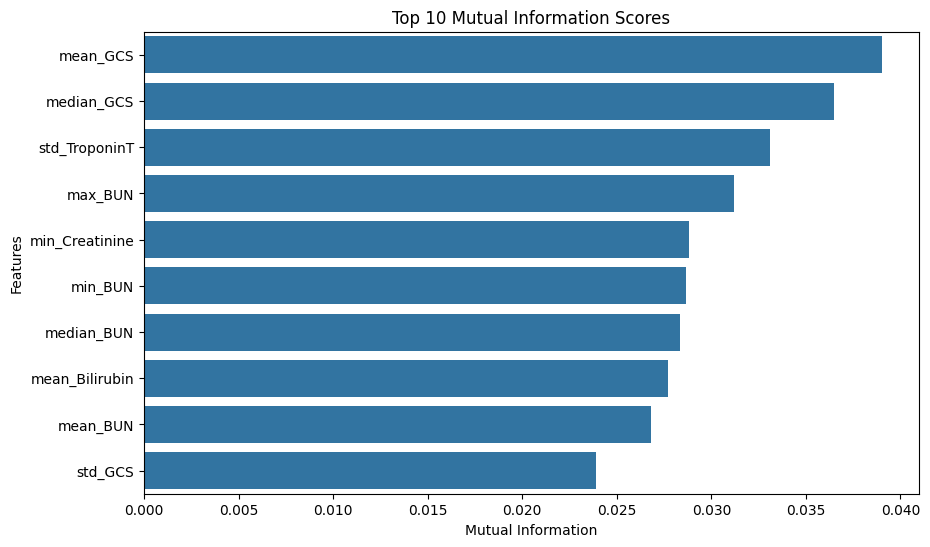

In [73]:
# calculate mutual information scores
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest


# create non-binary features dataset
non_binary_features = [
    c for c in X_train_cleaned.columns if len(set(X_train_cleaned[c])) > 2]
non_binary_train = X_train_cleaned[non_binary_features]

# knn imputer
imputer = KNNImputer(n_neighbors=5)
# impute missing values
non_binary_train_imputed = imputer.fit_transform(non_binary_train)
# convert to DataFrame
non_binary_train_imputed = pd.DataFrame(non_binary_train_imputed, columns=non_binary_train.columns[:non_binary_train_imputed.shape[1]])
# check for missing values
non_binary_train_imputed.isnull().sum().sort_values(ascending=False).head(20)

# calculate mutual information scores
mi_scores = mutual_info_classif(non_binary_train_imputed, y_train, random_state=rng)



# create a DataFrame of mutual information scores
mi_scores_df = pd.DataFrame(mi_scores, index=non_binary_train_imputed.columns, columns=["Mutual Information"])
mi_scores_df.sort_values(by="Mutual Information", ascending=False, inplace=True)
# plot mutual information scores
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores_df["Mutual Information"][:10], y=mi_scores_df.index[:10])
plt.title("Top 10 Mutual Information Scores")
plt.xlabel("Mutual Information")
plt.ylabel("Features")
plt.show()

